The passwords collected in this dataset are from 000webhost leak that is available
online. The goal is to choose classifier which must predict how weak or strong is the password?

### Libraries

In [297]:
import pandas as pd
import numpy as np
import seaborn as sns
import umap
import re

from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf

from sklearn.metrics import f1_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

### Importing data

In [143]:
data = pd.read_csv("data.csv", sep=',', names = ['password','strength','a','b','c'], skiprows=1)

### Data Preprocessing

There are rows with not only password and strength, so columns a, b, c were made to avoid this problem and handle them (in b will be password and in c strenght).

In [144]:
#data rows to be processed
data.loc[~data['a'].isnull()]

,password,strength,a,b,c
2808,selim,selim_syl1905@hotmail.com,88.230.79.161,Poftya123,2.0
4639,Selim,delioreanxs@hotmail.com,85.97.14.203,selim123456,2.0
7169,Selim,mt2gurur@hotmail.com,88.227.187.9,benerkin98,2.0
11218,Selim,facebookselim4@hotmail.com,94.123.218.111,4938863a,2.0
13807,selim,anakonda_252@hotmail.com,85.110.117.124,4560458sg,2.0
...,...,...,...,...,...
659781,Selim,cimbom_cadde@hotmail.com,212.253.60.7,05452121041s,2.0
660476,Selim,hajriz.balkansunflowers@gmail.com,87.238.209.50,selimi99,2.0
661131,selim,f4rr3ll26@gmail.com,78.165.183.171,43134278em,2.0
661734,Selim,deltoiddesign@hotmail.com,95.8.199.49,selim297@,2.0


In [145]:
for index, row in data.iterrows():
    if row['a'] is not np.nan or row['b'] is not np.nan:
        data.loc[index, 'password'] = row['b']
        data.loc[index, 'strength'] = row['c'] 

In [146]:
# processed data rows
data.loc[~data['a'].isnull()]

,password,strength,a,b,c
2808,Poftya123,2.0,88.230.79.161,Poftya123,2.0
4639,selim123456,2.0,85.97.14.203,selim123456,2.0
7169,benerkin98,2.0,88.227.187.9,benerkin98,2.0
11218,4938863a,2.0,94.123.218.111,4938863a,2.0
13807,4560458sg,2.0,85.110.117.124,4560458sg,2.0
...,...,...,...,...,...
659781,05452121041s,2.0,212.253.60.7,05452121041s,2.0
660476,selimi99,2.0,87.238.209.50,selimi99,2.0
661131,43134278em,2.0,78.165.183.171,43134278em,2.0
661734,selim297@,2.0,95.8.199.49,selim297@,2.0


Next step is to delete unuseful rows a, b, c and Nans

In [147]:
data.drop(columns=['a', 'b', 'c'], inplace = True)

In [148]:
data.dropna(inplace = True)

In [149]:
data['strength'] = data['strength']re

#### About next steps
It is well-known that how many and which characters are in password define its strength, so next step is extracting numbers of lower and upper case letters, symbols and numbers. 
Length of password  can strongly correlate, but I will try to train the model with and without this feature. Then I will train different classification models and compare results.

### Feature Engineering

Creating feature extraction functions

In [150]:
def extract_charachters(inpt):
    inpt= str(inpt)
    length = len(inpt)
    numbers = len(re.findall('[0-9]', inpt))
    upper = len(re.findall('[A-Z]', inpt))
    lower = len(re.findall('[a-z]',inpt))
    return length, numbers, upper, lower, (length - numbers - upper - lower)# last is symbols

In [151]:
def extract_length(inpt):
    return len(str(inpt))

def extract_numbers(inpt):
    return len(re.findall('[0-9]', str(inpt)))

def extract_uppers(inpt):
    return len(re.findall('[A-Z]', str(inpt)))

def extract_lowers(inpt):
    return len(re.findall('[a-z]', str(inpt)))

Creating and adding new features to dataframe

In [152]:
data['length']=pd.DataFrame(data['password'].apply(extract_length))
data['numbers']=pd.DataFrame(data['password'].apply(extract_numbers))
data['uppers']=pd.DataFrame(data['password'].apply(extract_uppers))
data['lowers']=pd.DataFrame(data['password'].apply(extract_lowers))
data['symbols'] = data['length'] -  data['numbers'] - data['uppers'] - data['lowers']

In [153]:
data

,password,strength,length,numbers,uppers,lowers,symbols
0,kzde5577,1,8,4,0,4,0
1,kino3434,1,8,4,0,4,0
2,visi7k1yr,1,9,2,0,7,0
3,megzy123,1,8,3,0,5,0
4,lamborghin1,1,11,1,0,10,0
...,...,...,...,...,...,...,...
669874,10redtux10,1,10,4,0,6,0
669875,infrared1,1,9,1,0,8,0
669876,184520socram,1,12,6,0,6,0
669877,marken22a,1,9,2,0,7,0


### Report from lib pandas_profiling

Here we can see correlations, distributions etc.

In [154]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Pandas Profiling Report")

In [155]:
profile

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Length of password has high correlation with 'uppers', but has high correlation with target as uppers feature, so I will try to train the model with and without that and choose best

### Splitting data into features and target

In [156]:
X = data.iloc[:, 2:].values
X_without_length = data.iloc[:, 3:].values
y = data.iloc[:, 1].values

In [157]:
np.random.seed(12)

### Splitting into train and test

Here is same splitting two different X - with length attribute and without.

In [158]:
#generate random indexes
test_i = np.random.choice(X.shape[0], int(X.shape[0] * 0.2), replace=False)
train_i = np.setdiff1d(np.array(range(X.shape[0])), test_i)

In [159]:
X_train = X[train_i, :]
X_train_wt_len = X_without_length[train_i, :]
X_test = X[test_i, :]
X_test_wt_len = X_without_length[test_i, :]
y_train = y[train_i]
y_test = y[test_i]

#### One-hot encoding (it will be needed for auc metrics and ANN)

In [160]:
enc = OneHotEncoder()
y_train_dummy = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_dummy = enc.transform(y_test.reshape(-1, 1)).toarray()

### Ridge Classifier

Training model with length attribute

In [165]:
classifier_ridge = RidgeClassifier()
classifier_ridge.fit(X_train, y_train)

RidgeClassifier()

In [166]:
y_pred = classifier_ridge.predict(X_test)

##### Since the classes are unevenly distributed (1st class 74%), then the accuracy metric will not be correct in this situation, therefore confusion matrix, precision, recall, f1-score, auc score is appropriate

<AxesSubplot:>

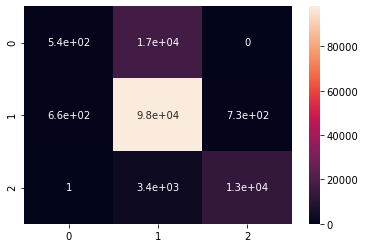

In [169]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [170]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.44787323, 0.82567116, 0.9480306 ]),
 array([0.03002852, 0.98604562, 0.79771429]),
 array([0.05628341, 0.89876016, 0.86640099]),
 array([17883, 99467, 16625], dtype=int64))

In [171]:
y_pred_dummy = enc.transform(y_pred.reshape(-1,1)).toarray()

In [172]:
roc_auc_score(y_test_dummy, y_pred_dummy, multi_class = 'ovr')

0.7002996964593254

In [173]:
classifier_ridge.coef_ # matrix(n_classes, n_features)

array([[-0.0752959 , -0.14480894,  0.00358859, -0.10080722,  0.16673168],
       [-0.07594754,  0.21313608, -0.10801068,  0.15531873, -0.33639168],
       [ 0.15124344, -0.06832714,  0.10442209, -0.05451151,  0.16966   ]])

Training model without length attribute

In [174]:
classifier_ridge = RidgeClassifier()
classifier_ridge.fit(X_train_wt_len, y_train)

RidgeClassifier()

<AxesSubplot:>

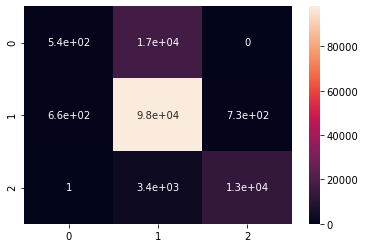

In [175]:
y_pred = classifier_ridge.predict(X_test_wt_len)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [176]:
y_pred_dummy = enc.transform(y_pred.reshape(-1,1)).toarray()

In [177]:
roc_auc_score(y_test_dummy, y_pred_dummy, multi_class = 'ovr')

0.7002996964593254

Results are satisfactory, but can be better with other models

### K-NN classification

Training model with length attribute

In [178]:
classifier_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [179]:
y_pred = classifier_knn.predict(X_test)

<AxesSubplot:>

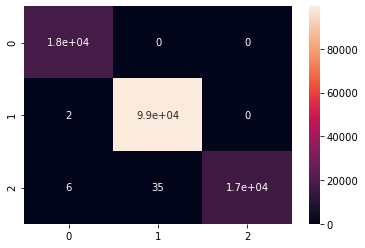

In [180]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [181]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.99955285, 0.99964824, 1.        ]),
 array([1.        , 0.99997989, 0.99753383]),
 array([0.99977637, 0.99981404, 0.99876539]),
 array([17883, 99467, 16625], dtype=int64))

In [182]:
y_pred_dummy = enc.transform(y_pred.reshape(-1,1)).toarray()

In [183]:
roc_auc_score(y_test_dummy, y_pred_dummy, multi_class = 'ovr')

0.9994050931646637

Training model with length attribute

In [184]:
classifier_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier_knn.fit(X_train_wt_len, y_train)

KNeighborsClassifier()

In [185]:
y_pred = classifier_knn.predict(X_test_wt_len)

<AxesSubplot:>

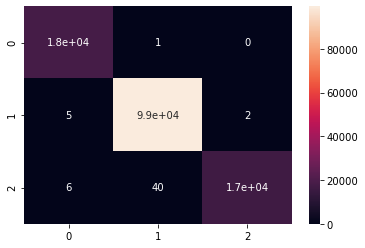

In [186]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [187]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.99938523, 0.99958794, 0.99987938]),
 array([0.99994408, 0.99992962, 0.99723308]),
 array([0.99966458, 0.99975876, 0.99855448]),
 array([17883, 99467, 16625], dtype=int64))

In [188]:
y_pred_dummy = enc.transform(y_pred.reshape(-1,1)).toarray()

In [189]:
roc_auc_score(y_test_dummy, y_pred_dummy, multi_class = 'ovr')

0.9993011438030385

This algorithm gives good results, but training and predicting was really slow 

### Naive Bayes Classifier

Training model with length attribute

In [190]:
classifier_Bayes = GaussianNB()
classifier_Bayes.fit(X_train, y_train)

GaussianNB()

<AxesSubplot:>

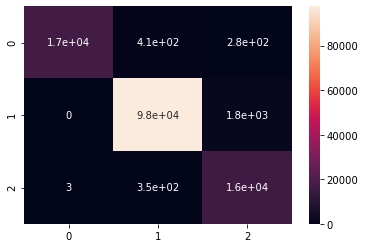

In [191]:
y_pred = classifier_Bayes.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [192]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.99982554, 0.99229636, 0.88511749]),
 array([0.96141587, 0.98160194, 0.97876692]),
 array([0.98024459, 0.98692018, 0.92958953]),
 array([17883, 99467, 16625], dtype=int64))

In [193]:
y_pred_dummy = enc.transform(y_pred.reshape(-1,1)).toarray()
roc_auc_score(y_test_dummy, y_pred_dummy, multi_class = 'ovr')

0.9802992532300494

Training model without length attribute

In [194]:
classifier_Bayes = GaussianNB()
classifier_Bayes.fit(X_train_wt_len, y_train)

GaussianNB()

<AxesSubplot:>

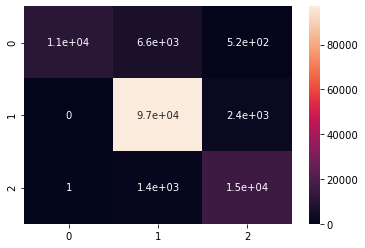

In [195]:
y_pred = classifier_Bayes.predict(X_test_wt_len)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [196]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.99990729, 0.92441057, 0.83803668]),
 array([0.60308673, 0.97559995, 0.91813534]),
 array([0.75238062, 0.9493157 , 0.87625936]),
 array([17883, 99467, 16625], dtype=int64))

In [197]:
y_pred_dummy = enc.transform(y_pred.reshape(-1,1)).toarray()
roc_auc_score(y_test_dummy, y_pred_dummy, multi_class = 'ovr')

0.8736213748240281

### Random Forest Classifier

Training model with length attribute

In [210]:
classifier_forest = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', random_state = 0)
classifier_forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=5, random_state=0)

<AxesSubplot:>

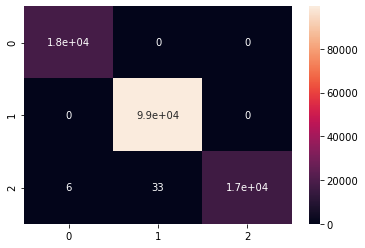

In [211]:
y_pred = classifier_forest.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [212]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.9996646 , 0.99966834, 1.        ]),
 array([1.        , 1.        , 0.99765414]),
 array([0.99983227, 0.99983414, 0.99882569]),
 array([17883, 99467, 16625], dtype=int64))

In [213]:
y_pred_dummy = enc.transform(y_pred.reshape(-1,1)).toarray()
roc_auc_score(y_test_dummy, y_pred_dummy, multi_class = 'ovr')

0.9994410253670148

Training model without length attribute

In [218]:
classifier_forest = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', random_state = 0)
classifier_forest.fit(X_train_wt_len, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=5, random_state=0)

<AxesSubplot:>

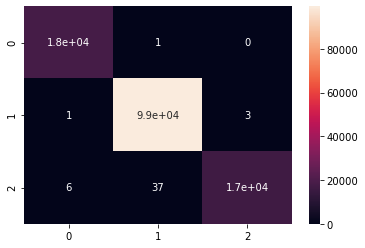

In [219]:
y_pred = classifier_forest.predict(X_test_wt_len)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [220]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.9996087 , 0.99961809, 0.99981911]),
 array([0.99994408, 0.99995979, 0.99741353]),
 array([0.99977636, 0.99978891, 0.99861488]),
 array([17883, 99467, 16625], dtype=int64))

In [221]:
y_pred_dummy = enc.transform(y_pred.reshape(-1,1)).toarray()
roc_auc_score(y_test_dummy, y_pred_dummy, multi_class = 'ovr')

0.9993550574967561

So after all these experiments,absence of attribute 'length' degrade the accuracy of some model, so it will not be in the final model

### Xgboost

In [222]:
xgbmodel = XGBClassifier(verbosity = 0, objective='multi:softprob', use_label_encoder=False)
xgbmodel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [223]:
y_pred = xgbmodel.predict(X_test)

<AxesSubplot:>

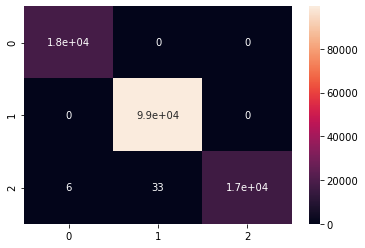

In [224]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [225]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.9996646 , 0.99966834, 1.        ]),
 array([1.        , 1.        , 0.99765414]),
 array([0.99983227, 0.99983414, 0.99882569]),
 array([17883, 99467, 16625], dtype=int64))

In [226]:
y_pred_dummy = enc.transform(y_pred.reshape(-1,1)).toarray()
roc_auc_score(y_test_dummy, y_pred_dummy, multi_class = 'ovr')

0.9994410253670148

### ANN 

In [289]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=15, activation='tanh'))
ann.add(tf.keras.layers.Dense(units=15, activation='tanh'))
ann.add(tf.keras.layers.Dense(units=3, activation='softmax'))

In [290]:
ann.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

In [291]:
ann.fit(X_train, y_train_dummy, batch_size=10000, epochs=200, verbose=0)

In [292]:
y_pred_raw = ann.predict(X_test)
y_pred = np.argmax(y_pred_raw, axis = 1)
y_pred_dummy = enc.transform(y_pred.reshape(-1, 1)).toarray()

<AxesSubplot:>

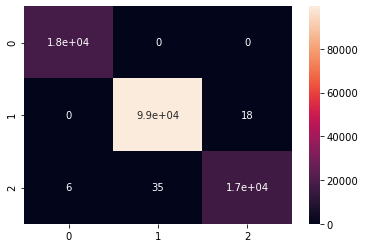

In [293]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [294]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.9996646 , 0.99964818, 0.99891579]),
 array([1.        , 0.99981904, 0.99753383]),
 array([0.99983227, 0.9997336 , 0.99822434]),
 array([17883, 99467, 16625], dtype=int64))

In [295]:
roc_auc_score(y_test_dummy, y_pred_dummy, multi_class = 'ovr')

0.9993555903385353

### Conslusion

So, after all experimants with different models, the best is xgboost, so next step is to train on all data and save model

In [296]:
xgbmodel = XGBClassifier(verbosity = 0, objective='multi:softprob', use_label_encoder=False)
xgbmodel.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [302]:
xgbmodel.save_model('xgbclassifier')